# DIFFERENT ACTIVATION FUNCTIONS
Należy rozszerzyć istniejącą implementację sieci i metody uczącej o możliwość wyboru funkcji aktywacji:

- sigmoid,  
- liniowa,  
- tanh,   
- ReLU.  
Pytanie dodatkowe – czy wszyscy implementują dokładnie gradient dla funkcji ReLU?  

Porównać szybkość uczenia i skuteczność sieci w zależności od liczby neuronów w poszczególnych warstwach i rodzaju funkcji aktywacji. Należy wziąć pod uwagę fakt, że różne funkcje aktywacji mogą dawać różną skuteczność w zależności od liczby neuronów i liczby warstw. Sprawdzić sieci z jedną, dwiema i trzema warstwami ukrytymi. Podobnie jak w poprzednim tygodniu, trzeba dostosować proces uczenia do pochodnych nowych funkcji aktywacji.  

Przeprowadzić testy wstępne dla zbioru multimodal-large (regresja), dla wszystkich trzech architektur i wszystkich czterech funkcji aktywacji.  

Dla pozostałych zbiorów wybrać dwa najlepsze zestawy i zbadać ich skuteczność:  

regresja:  
- steps-large,  

klasyfikacja: 
- rings5-regular
- rings3-regular

In [152]:
import pandas as pd
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score as f1
import matplotlib as mpl
np.random.seed(420)

In [2]:
def softmax(x): #https://stackoverflow.com/questions/42599498/numerically-stable-softmax
    x = x-x.max(axis=1).reshape(-1,1) # softmax(x) = softmax(x+c)
    return np.exp(x) / np.exp(x).sum(axis=1).reshape(-1,1)


def softmax_der(x):
    I = np.eye(x.shape[0])
    return softmax(x) * (I - softmax(x).T)


def cross_E(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred + 10**-10))


def one_hot(x):
    vals = np.unique(x)
    tmp = []
    for val in vals:
        tmp += [((x==val)*1).tolist()]
    return(np.array(tmp))

In [161]:
class MLP():
    def __init__(self, neurons, activation='sigmoid', activation_out='linear'):
        self.neurons = neurons
        self.weights = []
        self.biases = []
        self.activation = self.activ[activation]
        self.derivative = self.deriv[activation]
        self.outputActivation = self.activ[activation_out]
        self.outputDerivative = self.deriv[activation_out]
        self.dw_mean = []
        self.db_mean = []
        self.use_softmax = False
        if activation_out == 'softmax':
            self.use_softmax = True

        for i in range(len(self.neurons) - 1):
            self.weights += [np.random.uniform(-1, 1, neurons[i]
                                               * neurons[i + 1]).reshape(neurons[i], neurons[i + 1])]
            self.biases += [np.random.uniform(-1, 1,
                                              neurons[i + 1]).reshape(1, neurons[i+1])]

        
        self.mw = [np.zeros(w.shape) for w in self.weights]  # emthod weights
        self.mb = [np.zeros(b.shape) for b in self.biases]  # method biases

        pass

    activ = {
        'sigmoid': (lambda x: expit(x)),
        'tanh': (lambda x: np.tanh(x)),
        'Relu': (lambda x: np.multiply(x, x > 0)),
        'linear': (lambda x: np.array(x)),
        'softmax': (lambda x: softmax(x))
    }
    deriv = {
        'sigmoid': (lambda x: expit(x)*(1-expit(x))),
        'tanh': (lambda x: 1-np.square(np.tanh(x))),
        'Relu': (lambda x: 1 * (x > 0)),
        'linear': (lambda x: np.ones(x.shape)),
        'softmax':(lambda x: softmax_der(x))
    }

    def forward(self, x):
        self.A = [x]
        self.Z = []

        for layer in range(len(self.neurons)-2):
            net = np.dot(self.A[-1], self.weights[layer]) + self.biases[layer]
            output = self.activation(net)
            self.Z += [net]
            self.A += [output]
        net = np.dot(self.A[-1], self.weights[-1]) + self.biases[-1]
        y_hat = self.outputActivation(net)

        self.Z += [net]
        self.A += [y_hat]

        return y_hat

    def backprop(self, y):
        m = y.shape[0]
        Errors = [None] * len(self.weights)

        Errors[-1] = y-self.A[-1]

        for i in reversed(range(len(Errors)-1)):
            Errors[i] = (np.dot(self.weights[i+1], Errors[i+1].T)
                         * self.derivative(self.Z[i]).T).T

        dw = [None] * len(Errors)
        db = [None] * len(Errors)

        for i, e in enumerate(Errors):
            dw[i] = np.dot(e.T, self.A[i]).T / m
            db[i] = np.dot(e.T, np.ones([m, 1])).T / m

        return (dw, db)

    def learn_batch(self, x, y, batch_size=32, iterations=500, learning_rate=0.001, method='classic', decay=0.4):
        
            
        p = np.random.permutation(len(x))
        x = x[p]
        y = y[p]

        for iteration in range(iterations):
            i = 0
            while i < len(x): # dividing into batches
                x_batch = x[i: i+batch_size]
                y_batch = y[i: i+batch_size]
                i += batch_size

                self.forward(x_batch)
                (dw, db) = self.backprop(y_batch)

                self.dw_mean += [[np.mean(x) for x in dw]]
                self.db_mean += [[np.mean(x) for x in db]]

                if method == 'classic':
                    for j, w in enumerate(self.weights):
                        self.weights[j] = w + learning_rate*dw[j]
                    for j, b in enumerate(self.biases):
                        self.biases[j] = b + learning_rate*db[j]

                elif method == 'momentum':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + dw[j]
                        self.weights[j] = w + learning_rate * self.mw[j]
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + db[j]
                        self.biases[j] = b + learning_rate*self.mb[j]

                elif method == 'RMSprop':
                    for j, w in enumerate(self.weights):
                        self.mw[j] = decay * self.mw[j] + (1-decay) * np.square(dw[j])
                        self.weights[j] = w + learning_rate * dw[j] / (np.sqrt(self.mw[j]) + 1e-8)
                    for j, b in enumerate(self.biases):
                        self.mb[j] = decay * self.mb[j] + (1-decay) * np.square(db[j])
                        self.biases[j] = b + learning_rate * db[j] / (np.sqrt(self.mb[j]) + 1e-8)



    def classify(self,x):
        probability = self.forward(x)
        return [i.argmax() for i in probability]



In [174]:
def plot_train_test_classification(x_train, y_train, c_train, x_test, y_test, c_test):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle('Training set vs Test set')
    fig.set_size_inches(12,5)
    ax1.scatter(x_train, y_train, c=c_train, cmap=mpl.colormaps["Set2"])
    ax2.scatter(x_test, y_test, c=c_test, cmap=mpl.colormaps["Set2"])


def plot_compare_pred_classification(x,y,c, c_sigmoid,c_linear,c_tanh, c_relu):

    fig, ax = plt.subplots(1,5)
    fig.set_size_inches(24, 8)
    ax[0].scatter(x, y, c=c, cmap=mpl.colormaps["Set2"])
    ax[0].set_title('true')


    ax[1].scatter(x, y, c=c_sigmoid, cmap=mpl.colormaps["Set2"])
    ax[1].set_title('sigmoid')
    
    ax[2].scatter(x, y, c=c_linear, cmap=mpl.colormaps["Set2"])
    ax[2].set_title('linear')

    ax[3].scatter(x, y, c=c_tanh, cmap=mpl.colormaps["Set2"])
    ax[3].set_title('tanh')

    ax[4].scatter(x, y, c=c_relu, cmap=mpl.colormaps["Set2"])
    ax[4].set_title('Relu')
    print(f"F1: sigmoid = {f1(c, c_sigmoid, average = 'micro')}, linear = {f1(c, c_linear, average = 'micro')}, tanh = {f1(c, c_tanh, average = 'micro')}, relu = {f1(c, c_relu, average = 'micro')}")


def plot_mse(iter, mse_sigmoid, mse_linear, mse_tanh, mse_relu):
    plt.figure(figsize=(14, 8))
    plt.title("MSE values for different iteration number")
    plt.plot(iter, mse_sigmoid, marker='o', markerfacecolor='c',
             markersize=3, color='c', linewidth=2, linestyle='dotted')
    plt.plot(iter, mse_linear, marker='o', markerfacecolor='m',
             markersize=3, color='m', linewidth=2, linestyle='dotted')
    plt.plot(iter, mse_tanh, marker='o', markerfacecolor='y',
             markersize=3, color='y', linewidth=2, linestyle='dotted')
    plt.plot(iter, mse_relu, marker='o', markerfacecolor='y',
             markersize=3, color='black', linewidth=2, linestyle='dotted')
    plt.legend(['sigmoid', 'linear', 'tanh', 'relu'])


def plot_train_test_regression(x_train, y_train, x_test, y_test):
    fig, ax = plt.subplots(1, 2)
    fig.suptitle("Training set vs Test set")
    fig.set_size_inches(12,8)
    ax[0].plot(x_train, y_train, 'o', markersize = 3)
    ax[1].plot(x_test, y_test, 'o', markersize = 3)

def plot_compare_pred_regression(x,y,y_sigmoid,y_linear,y_tanh,y_relu):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
    fig.set_size_inches(24,8)
    ax1.set_title('sigmoid')
    ax1.scatter(x, y, s=10)
    ax1.scatter(x, y_sigmoid, s=6)
    ax2.set_title('linear')
    ax2.scatter(x, y, s=10)
    ax2.scatter(x, y_linear, s=6)
    ax3.set_title('tanh')
    ax3.scatter(x, y, s=10)
    ax3.scatter(x, y_tanh, s=6)
    ax4.set_title('relu')
    ax4.scatter(x, y, s=10)
    ax4.scatter(x, y_relu, s=6)
    print(f"MSE: , sigmoid = {mse(y, y_sigmoid)}, linear = {mse(y, y_linear)}, tanh, = {mse(y, y_tanh)}, relu : {mse(y, y_relu)}")

def mse(y, y_hat):
    return np.square(np.subtract(y, y_hat)).mean()


def plot_compare2_pred_regression(x,y,y_1,y_2):
    fig, (ax1, ax2) = plt.subplots(1,2)
    ax1.scatter(x, y, s=10)
    ax1.scatter(x, y_1, s=6)
    ax2.scatter(x, y, s=10)
    ax2.scatter(x, y_2, s=6)
    print(f"MSE 1 : {mse(y, y_1)}, MSE 2: {mse(y, y_2)}")

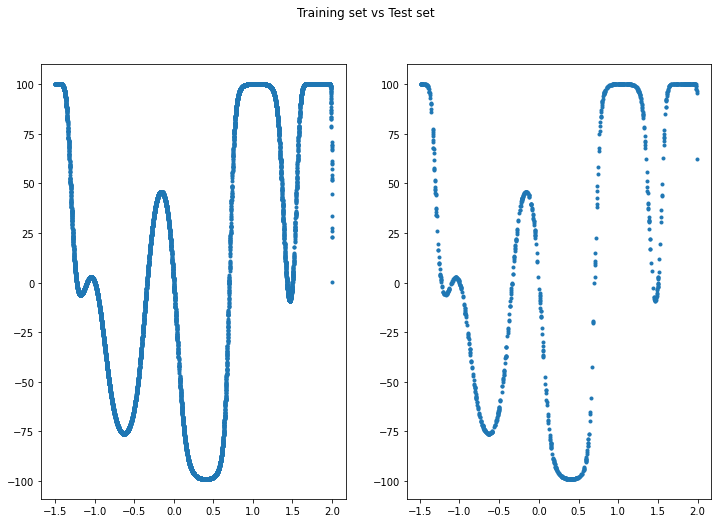

In [112]:
train_df = pd.read_csv("../dane/regression/multimodal-large-training.csv")
test_df = pd.read_csv("../dane/regression/multimodal-large-test.csv")

X_train = np.asarray(train_df['x']).reshape(-1,1)
Y_train = np.asarray(train_df['y']).reshape(-1,1)

X_test = np.asarray(test_df['x']).reshape(-1,1)
Y_test = np.asarray(test_df['y']).reshape(-1,1)

plot_train_test_regression(X_train, Y_train, X_test, Y_test)

In [113]:
neuron_sets = [[1,5,1], [1,10,1], [1,5,5,1], [1,10, 10, 10, 1]]
decay = 0.9
iterations = 100
lr_sigmoid = [0.001, 0.001, 0.0001, 0.005]
lr_linear = [0.001, 0.001, 0.001, 0.005]
lr_tanh = [0.001, 0.001, 0.0001, 0.005]
lr_relu = [0.0001, 0.001, 0.001, 0.005]

lr_sigmoid_best = [None, None, None, None]
lr_linear_best = [None, None, None, None]
lr_tanh_best = [None, None, None, None]
lr_relu_best = [None, None, None, None]
mse_sigmoid = [[], [], [], []]
mse_linear = [[], [],[], []]
mse_tanh = [[], [],[], []]
mse_relu = [[], [],[], []]

mse_best_sigmoid = [np.inf, np.inf, np.inf, np.inf]
mse_best_linear = [np.inf, np.inf, np.inf, np.inf]
mse_best_tanh = [np.inf, np.inf,np.inf, np.inf]
mse_best_relu = [np.inf, np.inf,np.inf, np.inf]

mlp_best_sigmoid = [None, None, None, None]
mlp_best_linear = [None, None, None,None]
mlp_best_tanh = [None, None, None,None]
mlp_best_relu = [None, None, None,None]


for i, neurons in enumerate(neuron_sets):
    mlp_sigmoid = MLP(neurons, activation='sigmoid')
    mlp_linear = MLP(neurons, activation='linear')
    mlp_tanh = MLP(neurons, activation='tanh')
    mlp_relu = MLP(neurons, activation='Relu')
    
    for iteration in range(iterations):
        mlp_sigmoid.learn_batch(X_train, Y_train, iterations = 1, learning_rate = lr_sigmoid[i], method='momentum', decay = 0.9)
        mlp_linear.learn_batch(X_train, Y_train, iterations = 1, learning_rate = lr_linear[i], method='momentum', decay = 0.7)
        mlp_tanh.learn_batch(X_train, Y_train, iterations = 1, learning_rate = lr_tanh[i], method='momentum', decay = 0.8)
        mlp_relu.learn_batch(X_train, Y_train, iterations = 1, learning_rate = lr_relu[i], method='momentum', decay = 0.75)

        y_sigmoid = mlp_sigmoid.forward(X_test)
        y_linear = mlp_linear.forward(X_test)
        y_tanh = mlp_tanh.forward(X_test)
        y_relu = mlp_relu.forward(X_test)

        mse_sigmoid[i].append(mse(Y_test, y_sigmoid))
        mse_linear[i].append(mse(Y_test, y_linear))
        mse_tanh[i].append(mse(Y_test, y_tanh))
        mse_relu[i].append(mse(Y_test, y_relu))


        if mse_best_sigmoid[i] > mse_sigmoid[i][-1]:
            mlp_best_sigmoid[i] = mlp_sigmoid
            mse_best_sigmoid[i] = mse_sigmoid[i][-1]
            lr_sigmoid_best[i] = lr_sigmoid[i]
        if mse_best_linear[i] > mse_linear[i][-1]:
            mlp_best_linear[i] = mlp_linear
            mse_best_linear[i] = mse_linear[i][-1]
            lr_linear_best[i] = lr_linear[i]
        if mse_best_tanh[i] > mse_tanh[i][-1]:
            mlp_best_tanh[i] = mlp_tanh
            mse_best_tanh[i] = mse_tanh[i][-1]
            lr_tanh_best[i] = lr_tanh[i]
        if mse_best_relu[i] > mse_relu[i][-1]:
            mlp_best_relu[i] = mlp_relu
            mse_best_relu[i] = mse_relu[i][-1]
            lr_relu_best[i] = lr_relu

        if (1+iteration) % 10 == 0:
            lr_sigmoid = np.multiply(decay, lr_sigmoid)
            lr_linear = np.multiply(decay, lr_linear)
            lr_tanh = np.multiply(decay, lr_tanh)
            lr_relu = np.multiply(decay, lr_relu)





### 5 neuronów, 1 warstwa

MSE: , sigmoid = 2629.798965111732, linear = 4440.91459883396, tanh, = 1655.6119648178628, relu : 1640.4307200795022


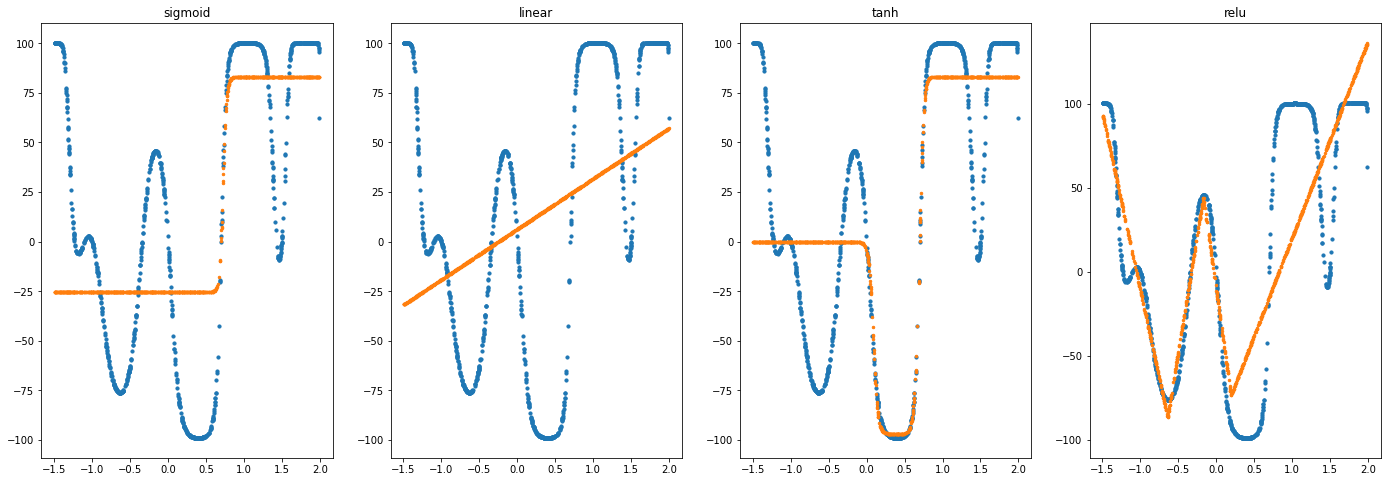

In [114]:
plot_compare_pred_regression(X_test, Y_test, mlp_best_sigmoid[0].forward(X_test), mlp_best_linear[0].forward(X_test), mlp_best_tanh[0].forward(X_test), mlp_best_relu[0].forward(X_test))

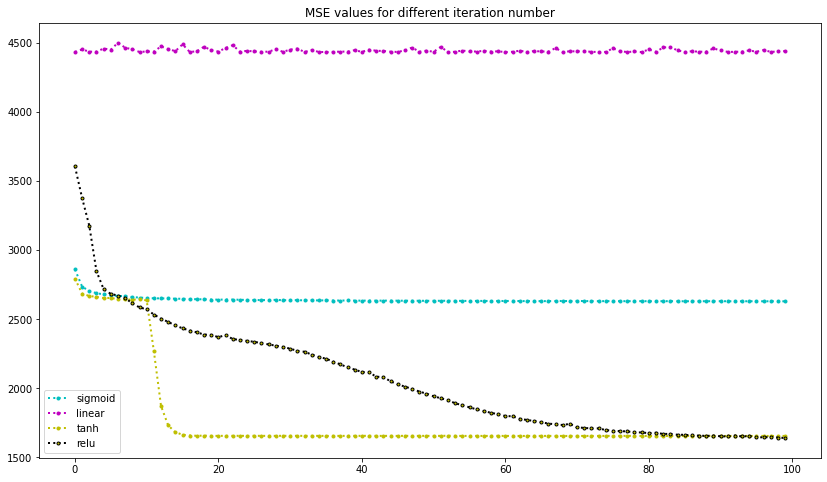

In [115]:
plot_mse(list(range(0, iterations, 1)), mse_sigmoid[0], mse_linear[0], mse_tanh[0], mse_relu[0])

### 10 neuronów, 1 warstwa

MSE: , sigmoid = 1026.886444200004, linear = 4434.08871492527, tanh, = 1588.013600710189, relu : 2769.0127908787636


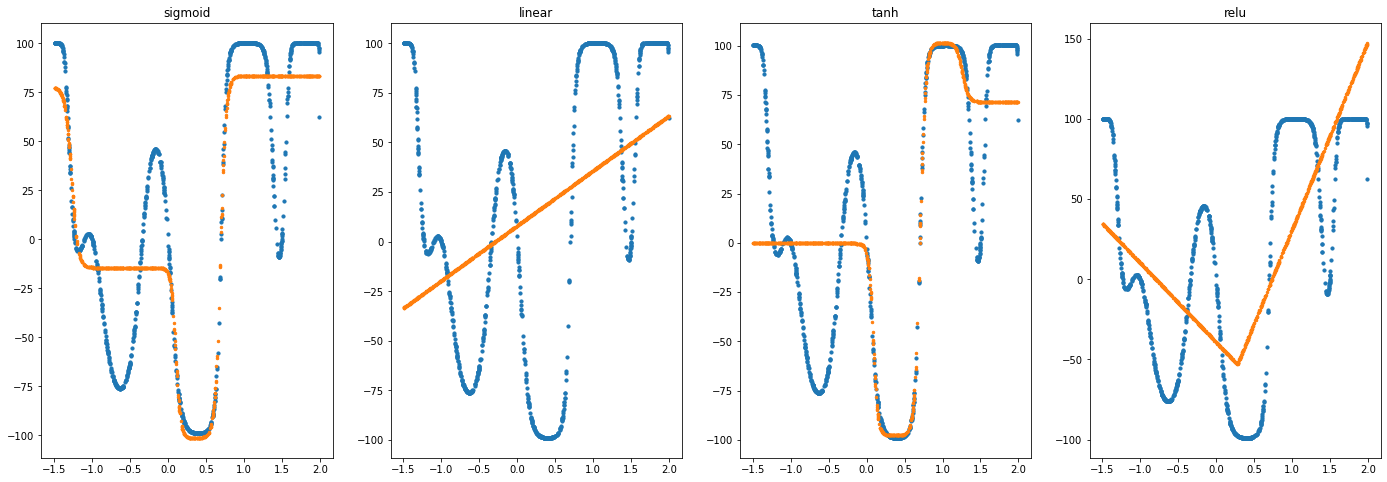

In [116]:
plot_compare_pred_regression(X_test, Y_test, mlp_best_sigmoid[1].forward(X_test), mlp_best_linear[1].forward(X_test), mlp_best_tanh[1].forward(X_test), mlp_best_relu[1].forward(X_test))

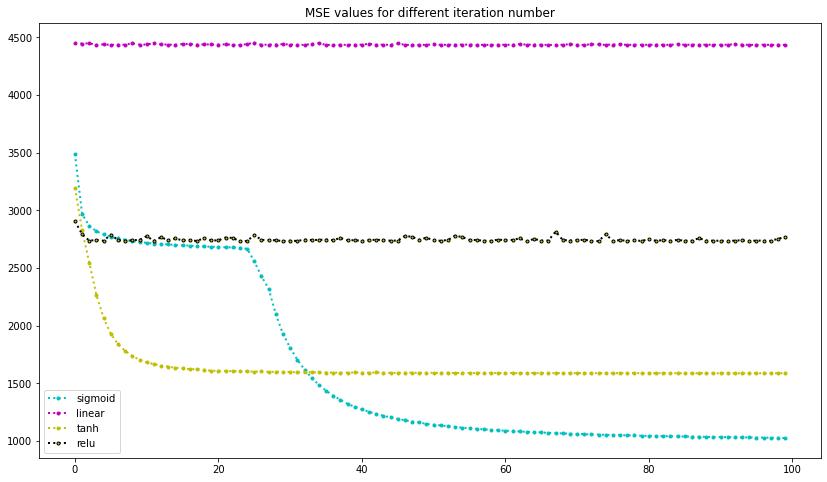

In [117]:
plot_mse(list(range(0, iterations, 1)), mse_sigmoid[1], mse_linear[1], mse_tanh[1], mse_relu[1])

### dwie warstwy po 5 neuronów

MSE: , sigmoid = 2838.4083807051193, linear = 4434.198871322408, tanh, = 2719.553293593562, relu : 1513.9587270692641


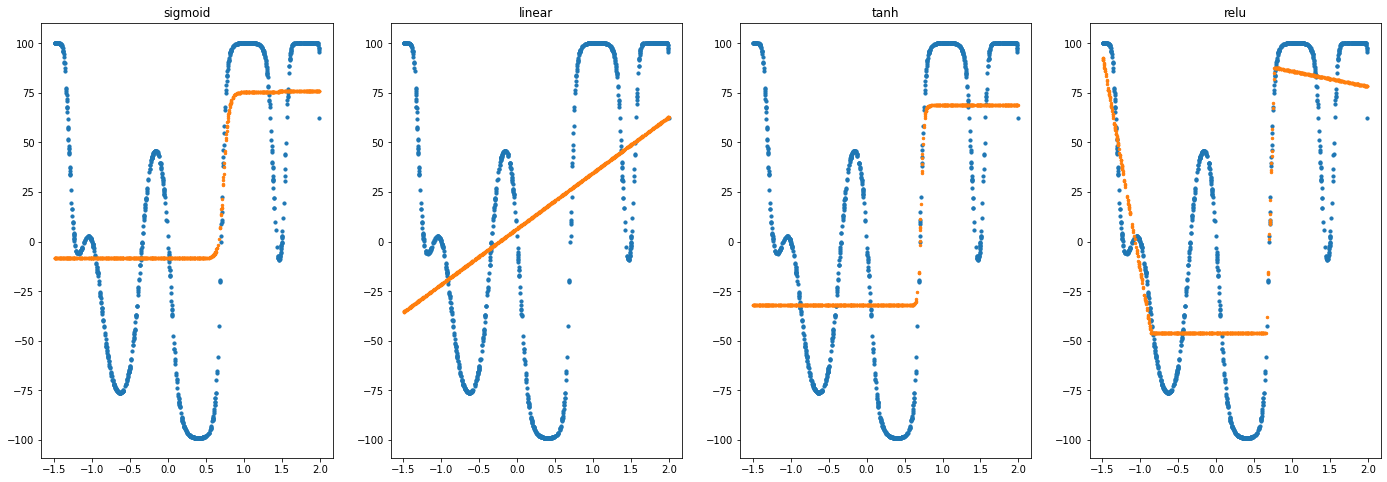

In [118]:
plot_compare_pred_regression(X_test, Y_test, mlp_best_sigmoid[2].forward(X_test), mlp_best_linear[2].forward(X_test), mlp_best_tanh[2].forward(X_test), mlp_best_relu[2].forward(X_test))

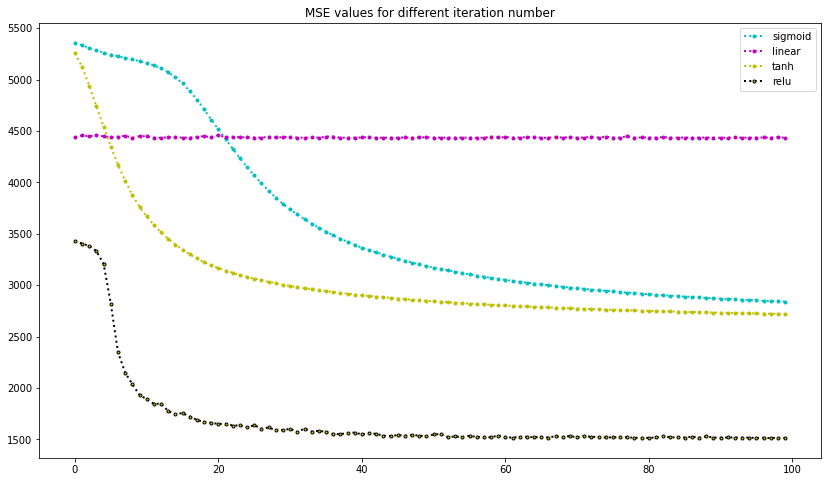

In [119]:
plot_mse(list(range(0, iterations, 1)), mse_sigmoid[2], mse_linear[2], mse_tanh[2], mse_relu[2])

### trzy warstwy po 10 neuronów

MSE: , sigmoid = 2624.3574121709707, linear = 4441.984287420236, tanh, = 1112.333972734684, relu : 127.02104175061808


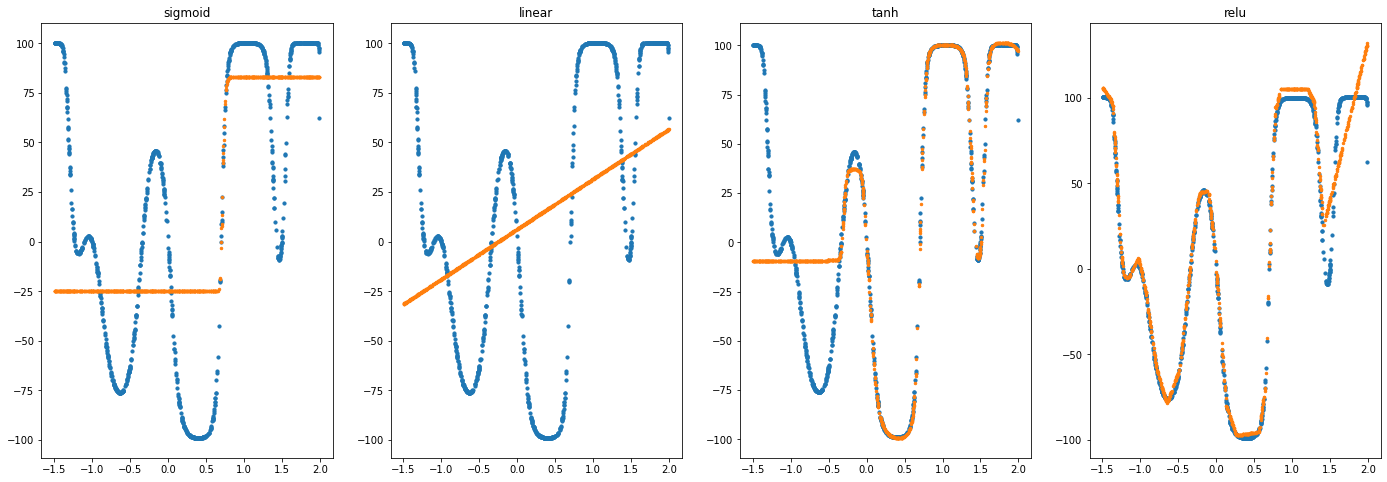

In [120]:
plot_compare_pred_regression(X_test, Y_test, mlp_best_sigmoid[3].forward(X_test), mlp_best_linear[3].forward(X_test), mlp_best_tanh[3].forward(X_test), mlp_best_relu[3].forward(X_test))

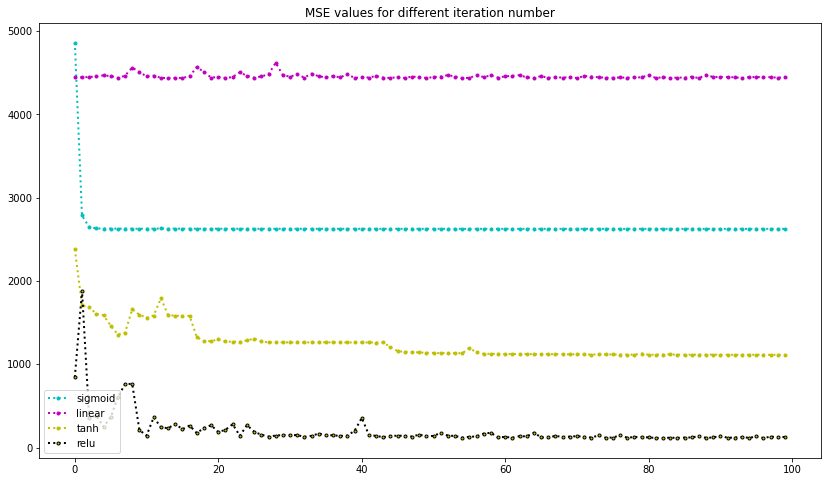

In [121]:
plot_mse(list(range(0, iterations, 1)), mse_sigmoid[3], mse_linear[3], mse_tanh[3], mse_relu[3])

#### dla mniejszych architektur sigmoid/tanh radzą sobie najlepiej, dla architektur kilkuwarstwowych - ReLu zdaje się być nienajgorszą opcją

### steps large

In [128]:
train_df = pd.read_csv('../dane/regression/steps-large-training.csv')
test_df = pd.read_csv('../dane/regression/steps-large-test.csv')

normalized_train_df=(train_df-train_df.mean())/train_df.std()

X_train = np.asarray(train_df['x']).reshape(-1, 1)
Y_train = np.asarray(train_df['y']).reshape(-1, 1)

X_normalized = np.asarray((train_df['x']-train_df['x'].mean())/train_df['x'].std()).reshape(-1, 1)
Y_normalized = np.asarray((train_df['y']-train_df['y'].mean())/train_df['y'].std()).reshape(-1, 1)

X_test = np.asarray(test_df['x']).reshape(-1,1)
Y_test = np.asarray(test_df['y']).reshape(-1, 1)

X_normalized_test = np.asarray((test_df['x']-test_df['x'].mean())/test_df['x'].std()).reshape(-1, 1)

In [145]:
neurons = [1,10,1]
decay = 0.9
iterations = 100
lr_tanh = 0.001
lr_relu = 0.0005

lr_tanh_best = None
lr_relu_best = None
mse_tanh = []
mse_relu = []

mse_best_tanh = np.inf
mse_best_relu = np.inf

mlp_best_tanh = None
mlp_best_relu = None



mlp_tanh = MLP(neurons, activation='tanh')
mlp_relu = MLP(neurons, activation='Relu')

for iteration in range(iterations):
    mlp_tanh.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_tanh, method='momentum', decay = 0.9)
    mlp_relu.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_relu, method='momentum', decay = 0.85)

    y_tanh = mlp_tanh.forward(X_test)
    y_relu = mlp_relu.forward(X_test)

    mse_tanh.append(mse(Y_test, y_tanh))
    mse_relu.append(mse(Y_test, y_relu))

    if mse_best_tanh > mse_tanh[-1]:
        mlp_best_tanh = mlp_tanh
        mse_best_tanh = mse_tanh[-1]
        lr_tanh_best = lr_tanh
    if mse_best_relu > mse_relu[-1]:
        mlp_best_relu = mlp_relu
        mse_best_relu = mse_relu[-1]
        lr_relu_best = lr_relu

    if (1+iteration) % 10 == 0:
        lr_tanh = np.multiply(decay, lr_tanh)
        lr_relu = np.multiply(decay, lr_relu)

y_tanh = mlp_best_tanh.forward(X_test)
y_relu = mlp_best_relu.forward(X_test)

MSE 1 : 27.264228013934456, MSE 2: 457.111324989549


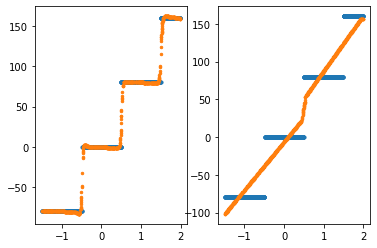

In [146]:
plot_compare2_pred_regression(X_test, Y_test, y_tanh, y_relu)

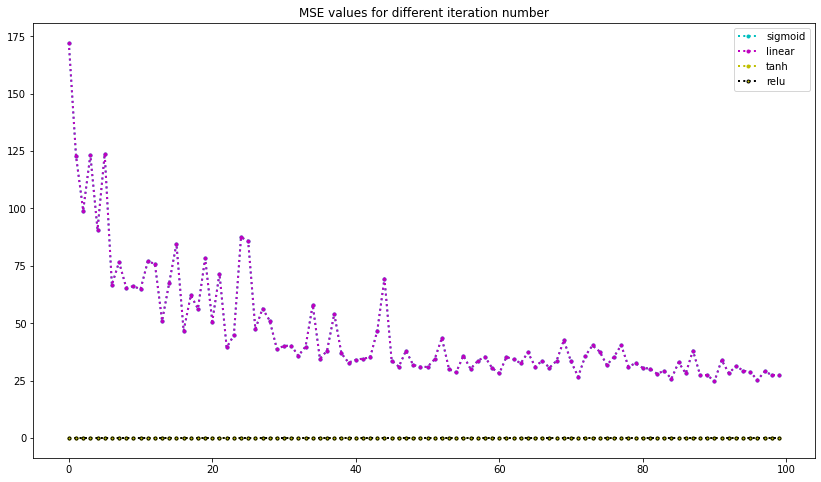

In [147]:
plot_mse(list(range(iterations)), mse_tanh, mse_tanh, [0]*iterations, [0]*iterations)

### klasyfikacja

#### rings-5-regular

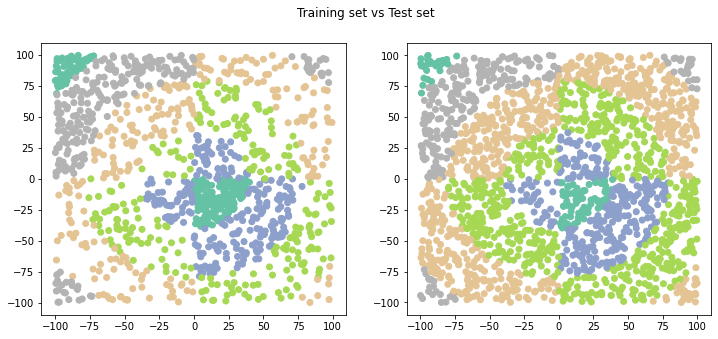

In [265]:
train_df = pd.read_csv("../dane/classification/rings5-regular-training.csv")
test_df = pd.read_csv("../dane/classification/rings5-regular-test.csv")

plot_train_test_classification(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [266]:
X_train = np.asarray(train_df[['x', 'y']])
X_test = np.asarray(test_df[['x', 'y']])

Y_train = np.asarray(train_df['c'])
Y_test = np.asarray(test_df['c'])

Y_train = np.array(one_hot(c)).T

In [273]:
neurons = [2 ,32, 32, 5]
decay = 0.9
iterations = 500
lr_sigmoid = 0.001
lr_linear = 0.0001
lr_tanh = 0.00005
lr_relu = 0.0001

lr_sigmoid_best = None
lr_linear_best = None
lr_tanh_best = None
lr_relu_best = None
f1_sigmoid = []
f1_linear = []
f1_tanh = []
f1_relu = []

f1_best_sigmoid = np.inf
f1_best_linear = np.inf
f1_best_tanh = np.inf
f1_best_relu = np.inf

mlp_best_sigmoid = None
mlp_best_linear = None
mlp_best_tanh = None
mlp_best_relu = None



mlp_sigmoid = MLP(neurons, activation='sigmoid', activation_out = 'softmax')
mlp_linear = MLP(neurons, activation='linear', activation_out = 'softmax')
mlp_tanh = MLP(neurons, activation='tanh', activation_out = 'softmax')
mlp_relu = MLP(neurons, activation='Relu', activation_out = 'softmax')

for iteration in range(iterations):
    mlp_tanh.learn_batch(X_train,Y_train,  iterations = 1, learning_rate = lr_sigmoid, method='momentum', decay = 0.9)
    mlp_relu.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_linear, method='momentum', decay = 0.7)
    mlp_tanh.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_tanh, method='momentum', decay = 0.85)
    mlp_relu.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_relu, method='momentum', decay = 0.75)

    y_sigmoid = mlp_sigmoid.classify(X_test)
    y_linear = mlp_linear.classify(X_test)
    y_tanh = mlp_tanh.classify(X_test)
    y_relu = mlp_relu.classify(X_test)

    f1_sigmoid.append(f1(Y_test, y_sigmoid, average = 'micro'))
    f1_linear.append(f1(Y_test, y_linear, average = 'micro'))
    f1_tanh.append(f1(Y_test, y_tanh, average = 'micro'))
    f1_relu.append(f1(Y_test, y_relu, average = 'micro'))

    if f1_best_sigmoid > f1_sigmoid[-1]:
        mlp_best_sigmoid = mlp_sigmoid
        f1_best_sigmoid = f1_sigmoid[-1]
        lr_sigmoid_best = lr_sigmoid
    if f1_best_linear > f1_linear[-1]:
        mlp_best_linear = mlp_linear
        f1_best_linear = f1_linear[-1]
        lr_linear_best = lr_linear
    if f1_best_tanh > f1_tanh[-1]:
        mlp_best_tanh = mlp_tanh
        f1_best_tanh = f1_tanh[-1]
        lr_tanh_best = lr_tanh
    if f1_best_relu > f1_relu[-1]:
        mlp_best_relu = mlp_relu
        f1_best_relu = f1_relu[-1]
        lr_relu_best = lr_relu

    if (1+iteration) % 25 == 0:
        lr_sigmoid = np.multiply(decay, lr_sigmoid)
        lr_linear = np.multiply(decay, lr_linear)
        lr_tanh = np.multiply(decay, lr_tanh)
        lr_relu = np.multiply(decay, lr_relu)

y_sigmoid = mlp_best_tanh.classify(X_test)
y_linear = mlp_best_relu.classify(X_test)
y_tanh = mlp_best_tanh.classify(X_test)
y_relu = mlp_best_relu.classify(X_test)

F1: sigmoid = 0.346, linear = 0.038, tanh = 0.547, relu = 0.6565


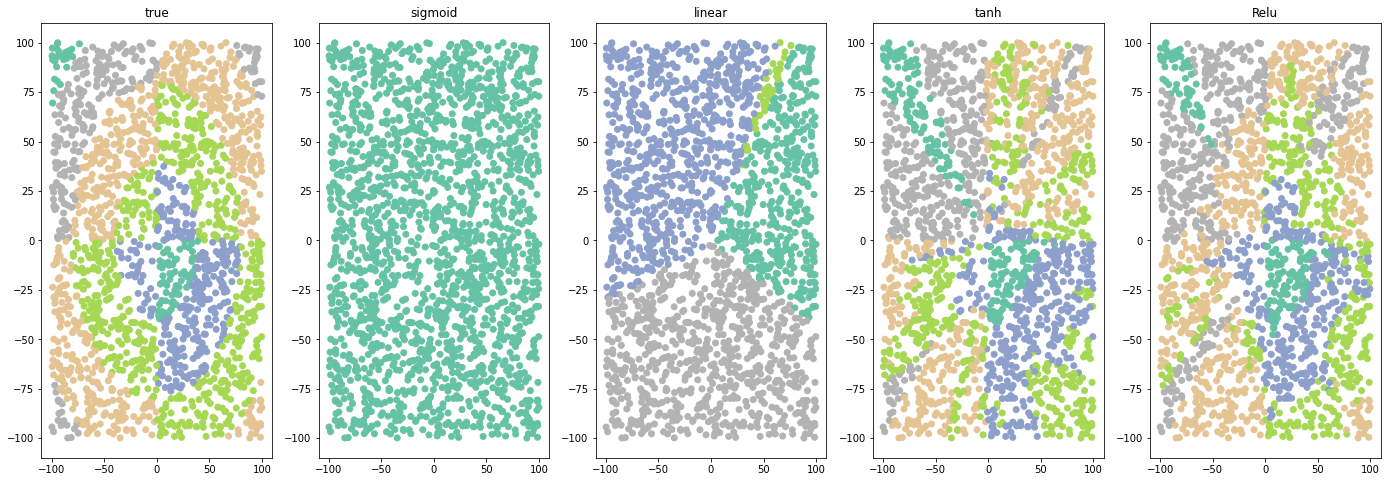

In [274]:
plot_compare_pred_classification(test_df['x'], test_df['y'], test_df['c'], mlp_sigmoid.classify(X_test), mlp_linear.classify(X_test), mlp_tanh.classify(X_test), mlp_relu.classify(X_test))

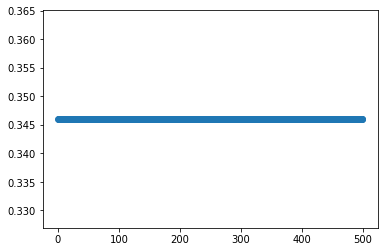

In [275]:
plt.scatter(list(range(len(f1_sigmoid))), f1_sigmoid)

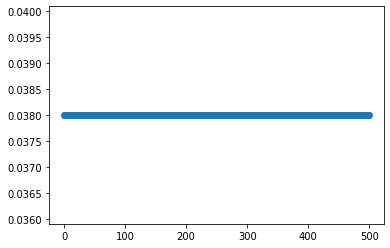

In [276]:
plt.scatter(list(range(len(f1_sigmoid))), f1_linear)

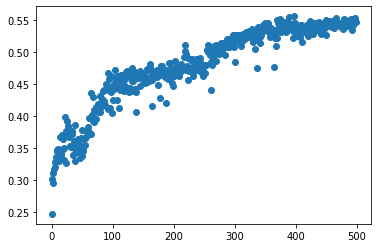

In [277]:
plt.scatter(list(range(len(f1_sigmoid))), f1_tanh)

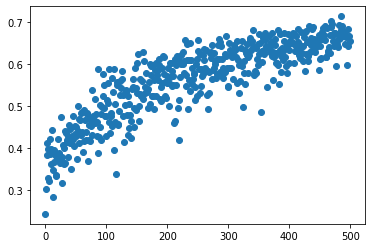

In [278]:
plt.scatter(list(range(len(f1_sigmoid))), f1_relu)

#### rings-3

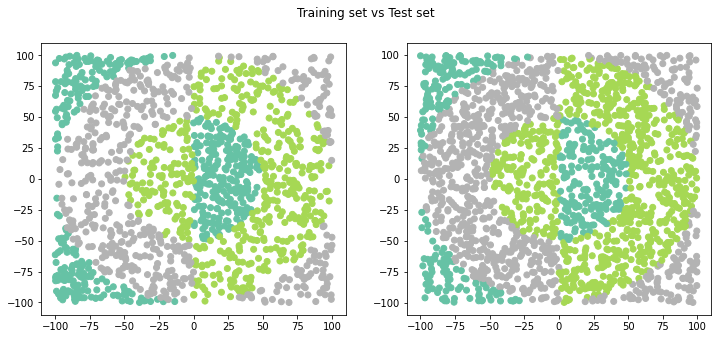

In [279]:
train_df = pd.read_csv("../dane/classification/rings3-regular-training.csv")
test_df = pd.read_csv("../dane/classification/rings3-regular-test.csv")

plot_train_test_classification(train_df['x'], train_df['y'], train_df['c'], test_df['x'], test_df['y'], test_df['c'])

In [280]:
X_train = np.asarray(train_df[['x', 'y']])
X_test = np.asarray(test_df[['x', 'y']])

Y_train = np.asarray(train_df['c'])
Y_test = np.asarray(test_df['c'])

Y_train = np.array(one_hot(Y_train)).T

In [281]:
neurons = [2 ,16, 16, 16, 3]
decay = 0.9
iterations = 200
lr_sigmoid = 0.0001
lr_linear = 0.001
lr_tanh = 0.001
lr_relu = 0.001

lr_sigmoid_best = None
lr_linear_best = None
lr_tanh_best = None
lr_relu_best = None
f1_sigmoid = []
f1_linear = []
f1_tanh = []
f1_relu = []

f1_best_sigmoid = np.inf
f1_best_linear = np.inf
f1_best_tanh = np.inf
f1_best_relu = np.inf

mlp_best_sigmoid = None
mlp_best_linear = None
mlp_best_tanh = None
mlp_best_relu = None



mlp_sigmoid = MLP(neurons, activation='sigmoid', activation_out = 'softmax')
mlp_linear = MLP(neurons, activation='linear', activation_out = 'softmax')
mlp_tanh = MLP(neurons, activation='tanh', activation_out = 'softmax')
mlp_relu = MLP(neurons, activation='Relu', activation_out = 'softmax')

for iteration in range(iterations):
    mlp_tanh.learn_batch(X_train,Y_train,  iterations = 1, learning_rate = lr_sigmoid, method='momentum', decay = 0.8)
    mlp_relu.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_linear, method='momentum', decay = 0.7)
    mlp_tanh.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_tanh, method='momentum', decay = 0.7)
    mlp_relu.learn_batch(X_train,Y_train, iterations = 1, learning_rate = lr_relu, method='momentum', decay = 0.7)

    y_sigmoid = mlp_sigmoid.classify(X_test)
    y_linear = mlp_linear.classify(X_test)
    y_tanh = mlp_tanh.classify(X_test)
    y_relu = mlp_relu.classify(X_test)

    f1_sigmoid.append(f1(Y_test, y_sigmoid, average = 'micro'))
    f1_linear.append(f1(Y_test, y_linear, average = 'micro'))
    f1_tanh.append(f1(Y_test, y_tanh, average = 'micro'))
    f1_relu.append(f1(Y_test, y_relu, average = 'micro'))

    if f1_best_sigmoid > f1_sigmoid[-1]:
        mlp_best_sigmoid = mlp_sigmoid
        f1_best_sigmoid = f1_sigmoid[-1]
        lr_sigmoid_best = lr_sigmoid
    if f1_best_linear > f1_linear[-1]:
        mlp_best_linear = mlp_linear
        f1_best_linear = f1_linear[-1]
        lr_linear_best = lr_linear
    if f1_best_tanh > f1_tanh[-1]:
        mlp_best_tanh = mlp_tanh
        f1_best_tanh = f1_tanh[-1]
        lr_tanh_best = lr_tanh
    if f1_best_relu > f1_relu[-1]:
        mlp_best_relu = mlp_relu
        f1_best_relu = f1_relu[-1]
        lr_relu_best = lr_relu

    if (1+iteration) % 25 == 0:
        lr_sigmoid = np.multiply(decay, lr_sigmoid)
        lr_linear = np.multiply(decay, lr_linear)
        lr_tanh = np.multiply(decay, lr_tanh)
        lr_relu = np.multiply(decay, lr_relu)

y_sigmoid = mlp_best_tanh.classify(X_test)
y_linear = mlp_best_relu.classify(X_test)
y_tanh = mlp_best_tanh.classify(X_test)
y_relu = mlp_best_relu.classify(X_test)

F1: sigmoid = 0.3325, linear = 0.225, tanh = 0.571, relu = 0.8715


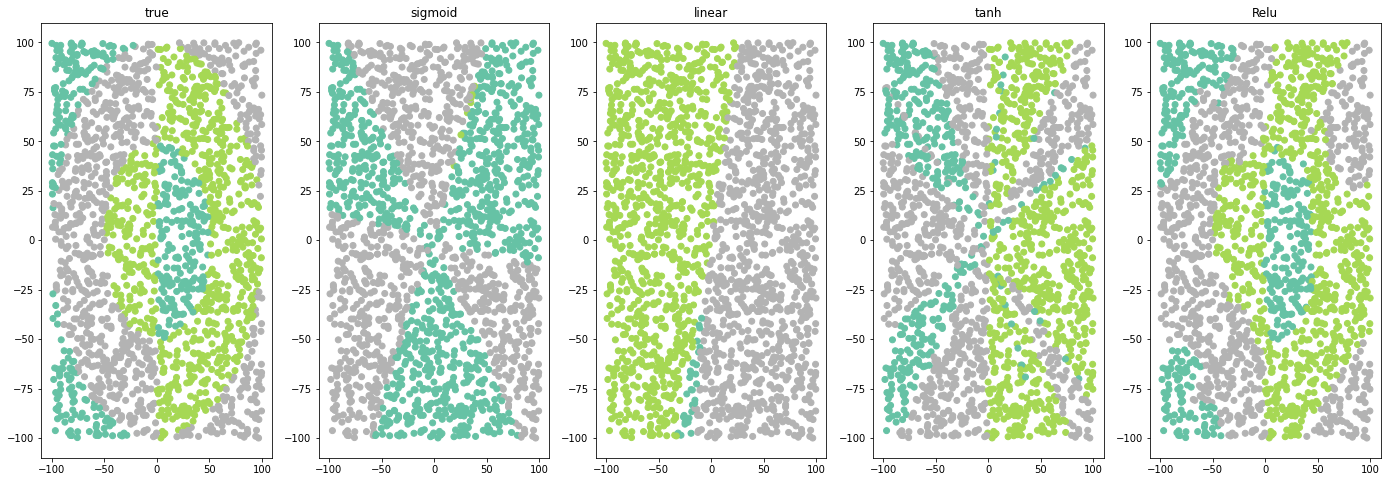

In [282]:
plot_compare_pred_classification(test_df['x'], test_df['y'], test_df['c'], mlp_sigmoid.classify(X_test), mlp_linear.classify(X_test), mlp_tanh.classify(X_test), mlp_relu.classify(X_test))

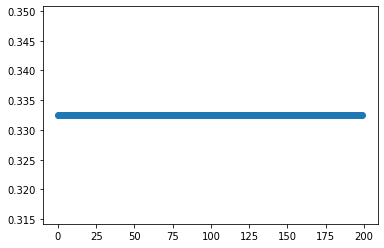

In [283]:
plt.scatter(list(range(len(f1_sigmoid))), f1_sigmoid)

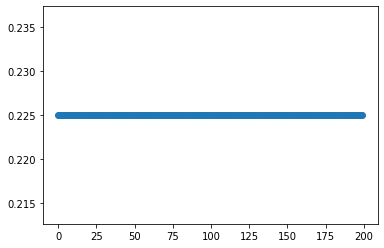

In [284]:
plt.scatter(list(range(len(f1_sigmoid))), f1_linear)

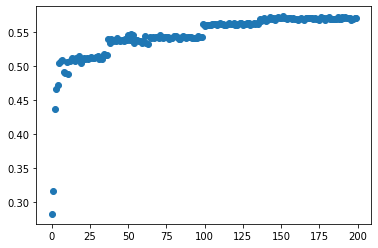

In [285]:
plt.scatter(list(range(len(f1_sigmoid))), f1_tanh)

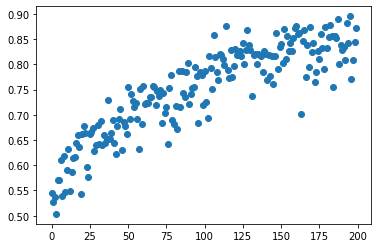

In [286]:
plt.scatter(list(range(len(f1_sigmoid))), f1_relu)